# Defect Classification Model

Here, we build a model to classify defects on a metal surface using Transfer Learning (with VGG16 base model).

**Dataset:** [Metal Surface Defects Dataset](https://www.kaggle.com/fantacher/neu-metal-surface-defects-data)

## Preliminaries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/My Drive/ME781/Project/defect_classification")

In [ ]:
import matplotlib
matplotlib.use("Agg")

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model
from keras.applications import VGG16
from keras.layers import Flatten, Dense, Dropout
from keras.preprocessing import image
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

## Model Architecture [Using VGG16 as Base Model]

In [ ]:
CLASSES = 6       # Here, there are 6 classes of defects ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled','Scratches']
HEIGHT = 224
WIDTH = 224
CHANNELS = 3

In [ ]:
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(WIDTH, HEIGHT, CHANNELS)))

# Enable Transfer Learning by freezing weights of the base VGG16 Model
for layer in baseModel.layers:
	layer.trainable = False

model = Sequential()
model.add(baseModel)
model.add(Flatten(name="flatten"))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(CLASSES, activation='softmax'))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 6)                 1

## Dataset Preparation

In [ ]:
# Image preprocessing for robustness
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
BATCH_SIZE = 36

print("[INFO] loading images...")
train_data_dir = "/content/drive/My Drive/ME781/Project/defect_classification/train"        # directory of training data
valid_data_dir = "/content/drive/My Drive/ME781/Project/defect_classification/valid"        # directory of validation data
test_data_dir = "/content/drive/My Drive/ME781/Project/defect_classification/test"          # directory of test data

training_set = train_datagen.flow_from_directory(train_data_dir,
                                                 target_size=(WIDTH, HEIGHT),
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical')
validation_set = train_datagen.flow_from_directory(valid_data_dir,
                                                 target_size=(WIDTH, HEIGHT),
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical')
test_set = test_datagen.flow_from_directory(test_data_dir,
                                            target_size=(WIDTH, HEIGHT),
                                            batch_size=BATCH_SIZE,
                                            class_mode='categorical',
                                            shuffle=False)

[INFO] loading images...
Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


## Model training

In [ ]:
print("[INFO] compiling model...")

model.compile(
    loss="categorical_crossentropy",
    optimizer = Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

[INFO] compiling model...


In [ ]:
print("[INFO] training model...")

EPOCHS = 10

history = model.fit(
    training_set,
    epochs=EPOCHS,
    steps_per_epoch=training_set.samples//BATCH_SIZE,
    validation_data=validation_set,
    validation_steps=validation_set.samples//BATCH_SIZE
)

[INFO] training model...
Epoch 1/10
46/46 [==============================] - 1207s 26s/step - loss: 1.9642 - accuracy: 0.5072 - val_loss: 0.3958 - val_accuracy: 0.9167
Epoch 2/10
46/46 [==============================] - 1218s 26s/step - loss: 0.5386 - accuracy: 0.8062 - val_loss: 0.1602 - val_accuracy: 0.9444
Epoch 3/10
46/46 [==============================] - 1214s 26s/step - loss: 0.3801 - accuracy: 0.8690 - val_loss: 0.1226 - val_accuracy: 0.9861
Epoch 4/10
46/46 [==============================] - 1221s 27s/step - loss: 0.3282 - accuracy: 0.8798 - val_loss: 0.1248 - val_accuracy: 0.9861
Epoch 5/10
46/46 [==============================] - 1180s 26s/step - loss: 0.3231 - accuracy: 0.8877 - val_loss: 0.1416 - val_accuracy: 0.9444
Epoch 6/10
46/46 [==============================] - 1141s 25s/step - loss: 0.3269 - accuracy: 0.8871 - val_loss: 0.1068 - val_accuracy: 1.0000
Epoch 7/10
46/46 [==============================] - 1157s 25s/step - loss: 0.2726 - accuracy: 0.9016 - val_loss: 0.04

In [ ]:
# Save the model
print("[Info] serializing network...")
model.save("defect_classification_vgg16.hdf5")

[Info] serializing network...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Function to plot the accuracy & losses over epochs of training

def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b*--', label="Training Accuracy")
    plt.plot(epochs, val_acc, 'rD:', label="Validation Accuracy")
    plt.legend()
    plt.title('Training and validation accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b*--', label="Training Loss")
    plt.plot(epochs, val_loss, 'rD:', label="Validation Loss")
    plt.legend()
    plt.title('Training and validation loss')

    plt.savefig("defect_classification_model.png", bbox_inches="tight")
    plt.show()

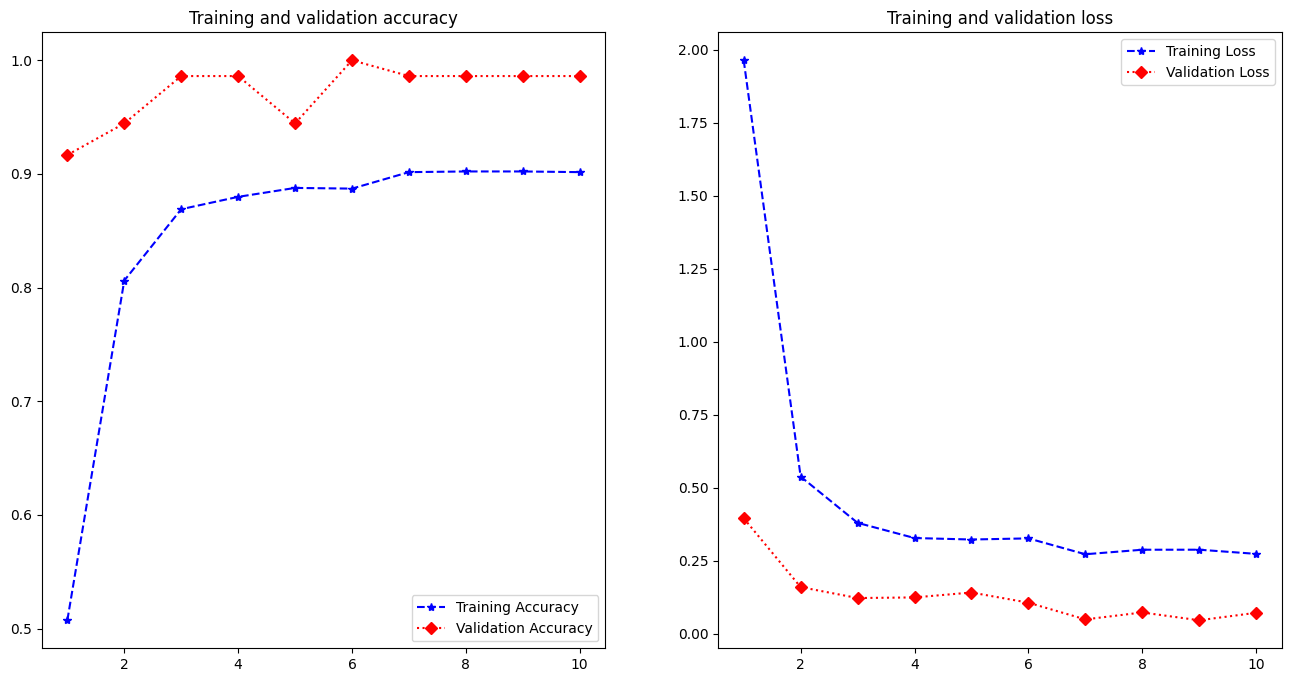

In [ ]:
plot_training(history)

## Model Evauation

In [ ]:
score = model.evaluate(test_set)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2/2 [==============================] - 51s 25s/step - loss: 0.0926 - accuracy: 0.9861
Test loss: 0.09258830547332764
Test accuracy: 0.9861111044883728


In [ ]:
pred = model.predict(
    test_set,
    steps=test_set.samples//BATCH_SIZE + 1,
    verbose=1
)
pred = np.argmax(pred, axis=1)

2/3 [===================>..........] - ETA: 23s

3/3 [==============================] - 46s 12s/step


In [ ]:
print('Confusion Matrix')
print(confusion_matrix(test_set.classes[test_set.index_array], pred))

print('\nClassification Report')
target_names = ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled','Scratches']
print(classification_report(test_set.classes[test_set.index_array], pred, target_names=target_names))

Confusion Matrix
[[12  0  0  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 11  1  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  0 12  0]
 [ 0  0  0  0  0 12]]

Classification Report
              precision    recall  f1-score   support

     Crazing       1.00      1.00      1.00        12
   Inclusion       1.00      1.00      1.00        12
     Patches       1.00      0.92      0.96        12
      Pitted       0.92      1.00      0.96        12
      Rolled       1.00      1.00      1.00        12
   Scratches       1.00      1.00      1.00        12

    accuracy                           0.99        72
   macro avg       0.99      0.99      0.99        72
weighted avg       0.99      0.99      0.99        72

